In [17]:
import os
import gdown
import zipfile
import pandas as pd
import numpy as np
import librosa
from IPython.display import Audio

import matplotlib.pyplot as plt

# Завантаження та розархівування датасету
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)
    os.remove(zip_file_path)


1. Для зменшення обсягу даних зробити вибірку звуків із мітками 'dog' та 'chirping_birds'.

In [18]:
import pandas as pd
# Read CSV file ... meta/esc50.csv
df_file_path = os.path.join(download_path, "ESC-50-master/meta", "esc50.csv")
df = pd.read_csv(df_file_path)
df_filtered = df[df['category'].isin(['dog', 'chirping_birds'])].reset_index(drop=True)
df_filtered.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-110389-A-0.wav,1,0,dog,True,110389,A
3,1-30226-A-0.wav,1,0,dog,True,30226,A
4,1-30344-A-0.wav,1,0,dog,True,30344,A


In [19]:
df_filtered

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-110389-A-0.wav,1,0,dog,True,110389,A
3,1-30226-A-0.wav,1,0,dog,True,30226,A
4,1-30344-A-0.wav,1,0,dog,True,30344,A
...,...,...,...,...,...,...,...
75,5-243450-A-14.wav,5,14,chirping_birds,False,243450,A
76,5-243459-A-14.wav,5,14,chirping_birds,False,243459,A
77,5-243459-B-14.wav,5,14,chirping_birds,False,243459,B
78,5-257839-A-14.wav,5,14,chirping_birds,False,257839,A


2. За допомогою наведеної в конспекті функції spectrogram згенерувати матрицю спектрограми.

In [20]:
def spectrogram(samples, sample_rate, stride_ms = 10.0,
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples,
                                          shape = nshape, strides = nstrides)

    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Compute spectrogram feature
    # ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:, :] + eps)
    return specgram

def pooling_audio(mat,ksize,method='max',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling,
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=np.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result


def load_audio(audio_file_path, frame=(10, 10), method = 'max'):

    y, sr = librosa.load(audio_file_path)
    spec = np.abs(librosa.stft(y))

    # Застосування пулінгу до спектрограми
    pooled_spec = pooling_audio(spec, frame, method=method)

    # Перетворення спектрограми у вектор
    flattened_spec = pooled_spec.flatten()

    return flattened_spec

3. Використати функцію pooling для узагальнення та зменшення розміру спектрограми.

In [22]:
chirping_birds = list(df_filtered.query("category == 'chirping_birds'").filename)
dog =  list(df_filtered.query("category == 'dog'").filename)

path_audiofile = os.path.join(download_path, "ESC-50-master/audio/{}")
path_audiofile[:]

'./ESC-50-master/ESC-50-master/audio/{}'

In [23]:
path_wav_validation = [
      ('chirping_birds', [os.path.exists(path_audiofile.format(filename)) for filename in chirping_birds]),
      ('dog', [os.path.exists(path_audiofile.format(filename)) for filename in dog])
]

for val_t, val in path_wav_validation:
      print(f'\33[0mall {val_t.upper()} path valid: ',
            ('\33[31mFalse','\33[32mTrue')[all(val)], '-', len(val))

path_wav = {
      'chirping_birds': [path_audiofile.format(filename) for filename in chirping_birds],
      'dog': [path_audiofile.format(filename) for filename in dog]
}

all CHIRPING_BIRDS path valid:  True - 40
all DOG path valid:  True - 40


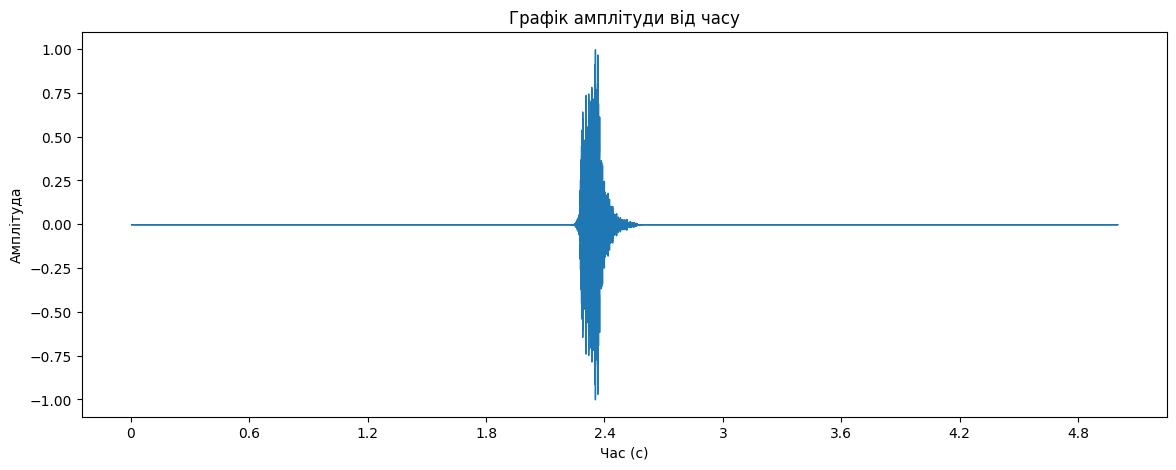

In [24]:
y, sr = librosa.load(path_wav['dog'][0], sr=None)
# audio_file_path = os.path.join(download_path, "ESC-50-master/audio", "1-100032-A-0.wav")
# y, sr = librosa.load(audio_file_path, sr=None)
# Зображення графіка амплітуди від часу
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Графік амплітуди від часу')
plt.xlabel('Час (с)')
plt.ylabel('Амплітуда')
plt.show()

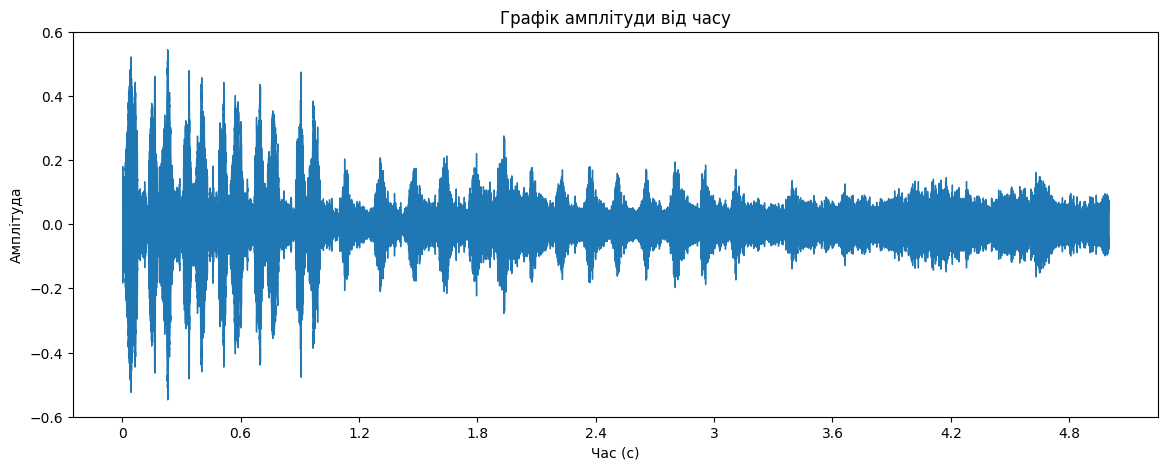

In [25]:
 y, sr = librosa.load(path_wav['chirping_birds'][0], sr=None)
# audio_file_path = os.path.join(download_path, "ESC-50-master/audio", "1-100038-A-14.wav")
# y, sr = librosa.load(audio_file_path, sr=None)
# Зображення графіка амплітуди від часу
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Графік амплітуди від часу')
plt.xlabel('Час (с)')
plt.ylabel('Амплітуда')
plt.show()

In [26]:
import plotly.graph_objects as go

def spect_show(spect_matrix, t):
    fig = go.Figure(data=go.Heatmap(z=spect_matrix, colorscale='viridis'))
    fig.update_layout(
        title=f'Візуалізація спектральної матриці {t}',
        xaxis_title='Номер фрейму',
        yaxis_title='Частота'
    )
    fig.show()

In [27]:
path_wav['dog'][0]

'./ESC-50-master/ESC-50-master/audio/1-100032-A-0.wav'

In [28]:
y, sr = librosa.load(path_wav['dog'][0], sr=None)
# audio_file_path = os.path.join(download_path, "ESC-50-master/audio", "1-100032-A-0.wav")
# y, sr = librosa.load(audio_file_path, sr=None)
spect_matrix_db = spectrogram(y, sr)
spect_show(spect_matrix_db, "dog")

Output hidden; open in https://colab.research.google.com to view.

In [29]:
from IPython.display import Audio, display

display(Audio(path_wav['dog'][0], autoplay=True))

In [30]:
y, sr = librosa.load(path_wav['chirping_birds'][0], sr=None)
# audio_file_path = os.path.join(download_path, "ESC-50-master/audio", "1-100038-A-14.wav")
# y, sr = librosa.load(audio_file_path, sr=None)
spect_matrix_db = spectrogram(y, sr)
spect_show(spect_matrix_db, 'chirping_birds')

Output hidden; open in https://colab.research.google.com to view.

In [31]:
y, sr = librosa.load(path_wav['dog'][0], sr=None)
# audio_file_path = os.path.join(download_path, "ESC-50-master/audio", "1-100032-A-0.wav")
# y, sr = librosa.load(audio_file_path, sr=None)
spec = np.abs(librosa.stft(y))

# Застосування пулінгу до спектрограми
pooled_spec_dog = pooling_audio(spec, (20, 20), method=None)  # Максимальне пулінгування
spect_show(pooled_spec_dog, 'dog pooling')

In [32]:
# y, sr = librosa.load(path_wav['chirping_birds'][0], sr=None)
audio_file_path = os.path.join(download_path, "ESC-50-master/audio", "1-100038-A-14.wav")
y, sr = librosa.load(audio_file_path, sr=None)
spec = np.abs(librosa.stft(y))

# Застосування пулінгу до спектрограми
pooled_spec_chirping_birds = pooling_audio(spec, (20, 20), method=None)  # Максимальне пулінгування
spect_show(pooled_spec_chirping_birds, 'chirping_birds pooling')

4. За допомогою методу flaten() перетворити матрицю спектрограми у вектор для подальшого спектрального аналізу.

In [33]:
# Перетворення спектрограми у вектор
flattened_spec_dog = pooled_spec_dog.flatten()
flattened_spec_chirping_birds = pooled_spec_chirping_birds.flatten()

print("Розмірність вектору спектрограми для dog:", flattened_spec_dog.shape)
print("Розмірність вектору спектрограми для chirping_birds:", flattened_spec_chirping_birds.shape)

Розмірність вектору спектрограми для dog: (1071,)
Розмірність вектору спектрограми для chirping_birds: (1071,)


In [34]:
audio_data_dog_and_chirping_birds = [load_audio(file) for file in np.concatenate((path_wav['dog'], path_wav['chirping_birds']))]

In [35]:
true_labels = df_filtered['target'].replace(14,1)

print(len(audio_data_dog_and_chirping_birds),
      len(audio_data_dog_and_chirping_birds[0]),
      sep='\n')

80
2142


5. Використати функцію SpectralClustering бібліотеки sklearn для кластеризації отриманих даних (аналогічно до ДЗ теми №1).

In [36]:
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import copy
import itertools

# Define the range of hyperparameters to search over
param_grid = {
    'n_clusters': [2],
    'affinity': ['nearest_neighbors'],
    'gamma': [1, 10, 50, 100],
    'assign_labels': ['kmeans', 'discretize', 'cluster_qr']
}

scaler = StandardScaler()

shapes = [data.shape for data in audio_data_dog_and_chirping_birds]

# Find the maximum shape
max_shape = max(shapes)

# Reshape all elements to have the same shape
audio_data_fixed = [np.pad(data, [(0, max_shape[0] - data.shape[0])], mode='constant') if data.shape != max_shape else data
                    for data in audio_data_dog_and_chirping_birds]

X_normalized = scaler.fit_transform(audio_data_fixed)

best_accuracy = 0
best_precision = 0 # Initialize the best ARI
best_params = None  # Initialize the best parameters

# Використання itertools.product для генерації всіх можливих комбінацій параметрів
for params in itertools.product(param_grid['n_clusters'],
                                param_grid['affinity'],
                                param_grid['gamma'],
                                param_grid['assign_labels']):

    n_clusters, affinity, gamma, assign_labels = params

    # Create the SpectralClustering model with current hyperparameters
    model = SpectralClustering(n_clusters=n_clusters, affinity=affinity, gamma=gamma, assign_labels=assign_labels, random_state=42)

    try:
        # Perform clustering
        clusters = model.fit_predict(X_normalized)
    except Exception as e:
        print('')

    # Evaluate the clustering performance using ARI
    ari = adjusted_rand_score(true_labels, clusters)
    # accuracy = accuracy_score(true_labels, clusters)
    precision = precision_score(true_labels, clusters)
    recall = recall_score(true_labels, clusters)
    f1 = f1_score(true_labels, clusters)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, clusters)
    # Calculate the sum of diagonal elements (correct predictions)
    correct_predictions = np.trace(conf_matrix)

    # Calculate the total number of predictions
    total_predictions = np.sum(conf_matrix)

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions

    # Update the best parameters if ARI is improved
    if precision > best_precision:
        best_precision = precision
        best_params = {'n_clusters': n_clusters, 'affinity': affinity, 'gamma': gamma, 'assign_labels': assign_labels}
        best_clusters = copy.copy(clusters)
        # Print metrics for each combination
        print("Parameters:", {'n_clusters': n_clusters, 'affinity': affinity, 'gamma': gamma, 'assign_labels': assign_labels})
        print("Adjusted Rand Index (ARI):", ari)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1)
        print()


# Print the best parameters found
print("\33[32mBest Parameters:", best_params)
print("\33[32mAdjusted Rand Index (ARI) of the best model:", best_accuracy)

Parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors', 'gamma': 1, 'assign_labels': 'kmeans'}
Adjusted Rand Index (ARI): 0.0072130153436156036
Accuracy: 0.4375
Precision: 0.35294117647058826
Recall: 0.15
F1-score: 0.21052631578947367

Parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors', 'gamma': 1, 'assign_labels': 'discretize'}
Adjusted Rand Index (ARI): -0.00984898752088513
Accuracy: 0.4875
Precision: 0.4782608695652174
Recall: 0.275
F1-score: 0.3492063492063492

Parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors', 'gamma': 1, 'assign_labels': 'cluster_qr'}
Adjusted Rand Index (ARI): -0.00984898752088513
Accuracy: 0.5125
Precision: 0.5087719298245614
Recall: 0.725
F1-score: 0.5979381443298969

Best Parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors', 'gamma': 1, 'assign_labels': 'cluster_qr'}
Adjusted Rand Index (ARI) of the best model: 0


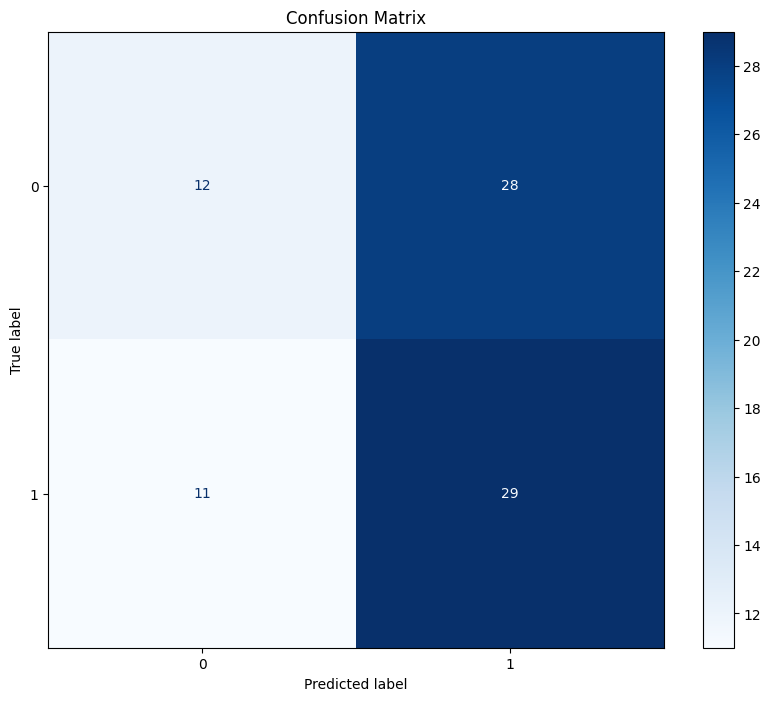

In [37]:
model = SpectralClustering(**best_params)
clusters = model.fit_predict(X_normalized)
clusters = best_clusters

df_filtered['predicted'] = clusters

# Extract predicted and true labels
predicted_labels = df_filtered['predicted']
true_labels = df_filtered['target'].replace(14,1)
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df_filtered['target'].replace(14,1).unique())
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [38]:
df_filtered['target'].replace(14,1).value_counts()

,count
target,
0,40
1,40


In [39]:
df_filtered['target'].replace(14,1).value_counts()

,count
target,
0,40
1,40


Аналіз отриманих результатів
З трьох варіантів найкращі результати отримано при використанні методу 'assign_labels': 'cluster_qr', для якого значення Accuracy становить 51.25%, а F1-score – 0.60. Хоча показник ARI для всіх моделей дуже низький, це може свідчити про низький рівень схожості між істинними та передбаченими кластерами.
Низький ARI і точність вказують, що кластеризація не змогла повністю розділити звуки різного походження на окремі кластери, що може бути пов'язано зі складністю спектральних особливостей або обраним параметром подібності.

Висновок
Кластеризація дала посередні результати, можливо, через недостатню відмінність у спектральних ознаках між звуками "dog" та "chirping_birds".